In this post, we use the Census Income data set from UCI repository to demonstrate feature processing procedures. We then use logistic regression to build a binary classification model to predict if a given user's income will be above or below.

The data set can be found on UCI repo website:
https://archive.ics.uci.edu/ml/datasets/Census+Income

The procedure used to process categorical features is also discussed in another post (on simpler artificial data set)
https://github.com/cheng-w-liu/computational-notes/blob/master/Machine_Learning_algorithms/processing_categorical_features.ipynb 


In [106]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sbn
%matplotlib inline
matplotlib.style.use('ggplot')

In [70]:
file_name = 'adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income_level']

column_types = {'age': int, 
               'workclass': str,
               'fnlwgt': int,
               'education': str,
               'education-num': int,
               'marital-status': str,
               'occupation': str,
               'Protective-serv': str,
               'relationship': str, 
               'race': str,
               'sex': str, 
               'capital-gain': int, 
               'capital-loss': int, 
               'hours-per-week': int, 
               'native-country': str, 
               'income_level': str}
data_df = pd.read_csv(file_name, header=None, names=column_names, dtype=column_types)
TARGET = 'response'
data_df[TARGET] = (data_df['income_level'] == ' >50K').astype(int)

# These two numerical numbers have really imbalanced distribution, meaning that 
#  majority are 0 but a few have really high values. 
#   Use log-transform to normalize the scale
data_df['capital-gain'] = np.log(data_df['capital-gain'] + 1)
data_df['capital-loss'] = np.log(data_df['capital-loss'] + 1)

In [71]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

/Users/chengweiliu/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


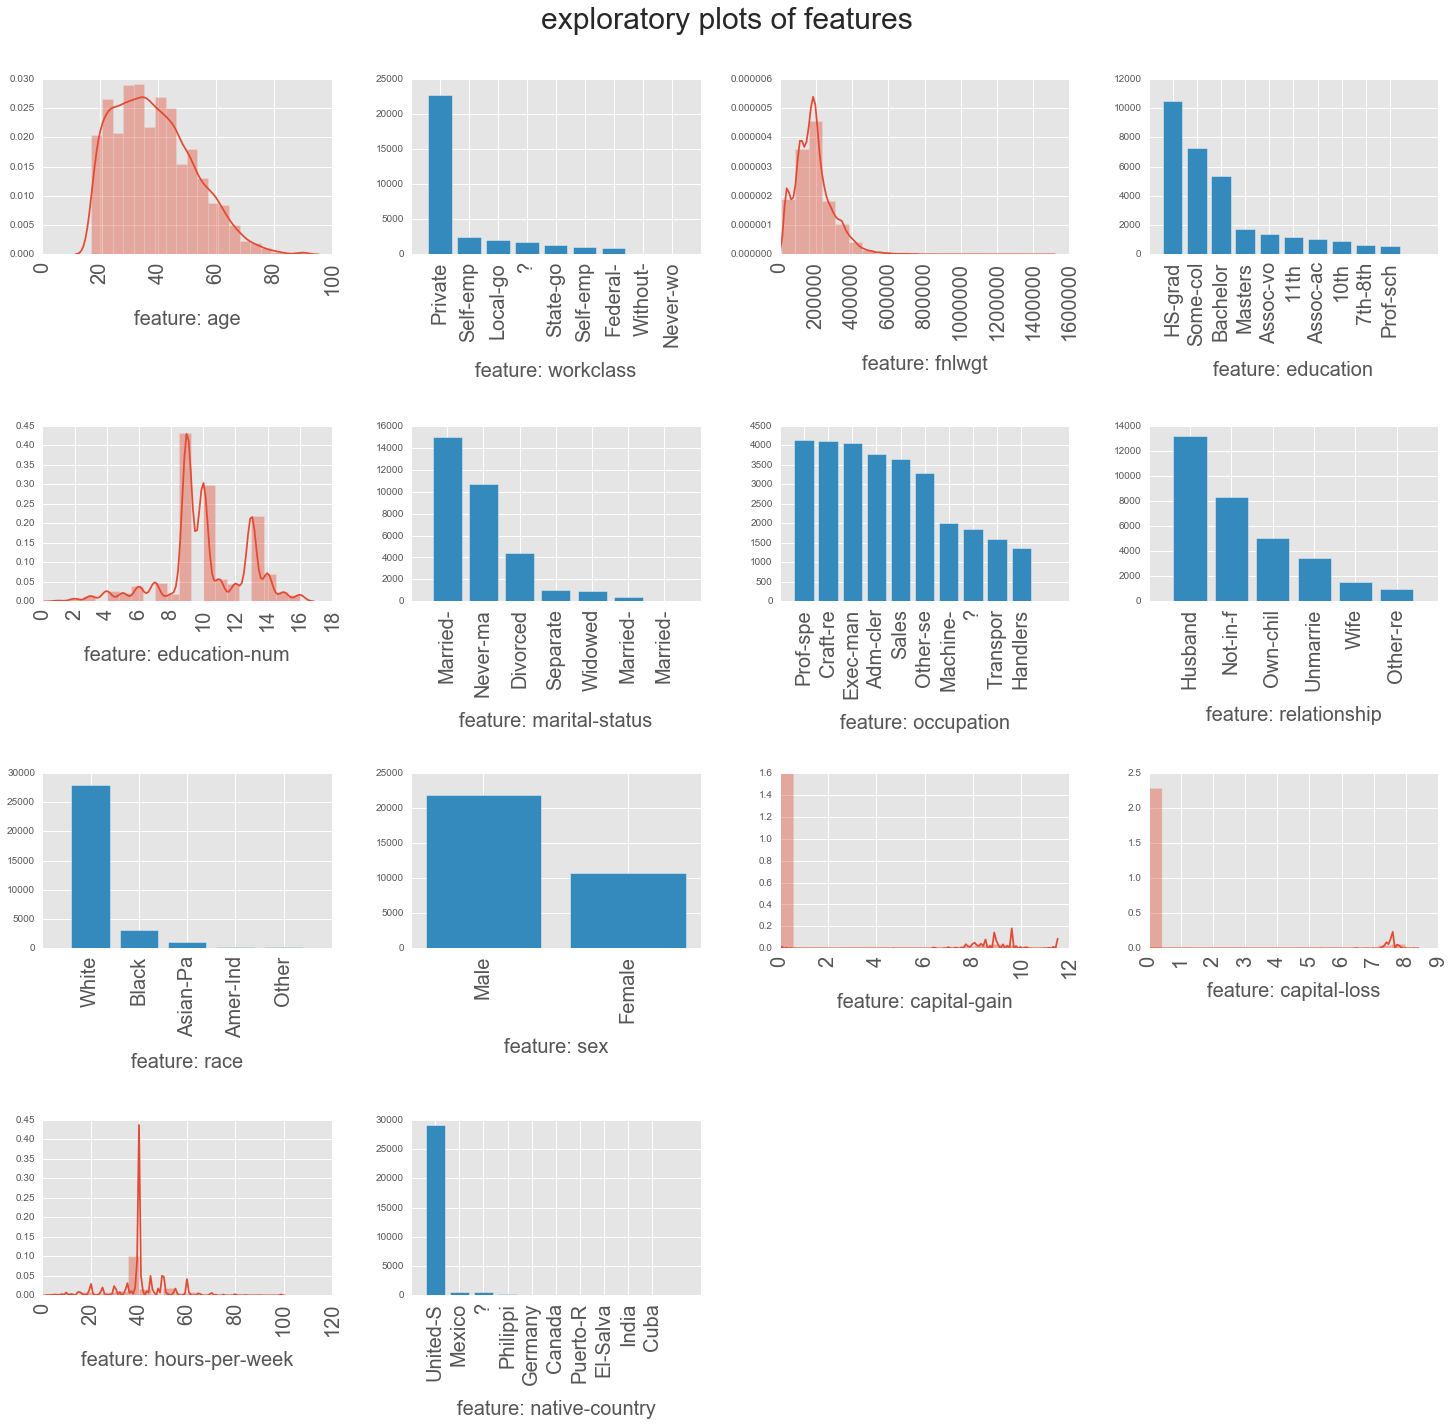

In [72]:
# We first plot the distribution of each feature. 
#  For categorical features, we plot the histogram for the top 10 ominals. 
#  For numerical features, we simply plot the binned histogram and kde
# 
FONTSIZE = 20
plt.close('all')
fig = plt.figure(figsize=(20, 20))
Lv = 4
Lh = 4
gs = matplotlib.gridspec.GridSpec(Lv, Lh)
for i, feature in enumerate(column_names[0:-1]):
    
    v_ind = i//Lv    
    h_ind = i%Lh    
    ax = plt.subplot(gs[v_ind, h_ind])
    
    if column_types[feature]==str:
        # boxplot
        s = data_df[feature].copy()
        top_value_counts = s.value_counts().head(10)
        categories = [cate.strip()[0:8] for cate in top_value_counts.index.tolist()]
        idx = np.arange(len(categories)) + 1
        ax.bar(idx, top_value_counts.values, align='center')
        ax.set_xticks(idx)
        ax.set_xticklabels(categories)
        adjustAxeProperties(ax, FONTSIZE, 90, 0.5*FONTSIZE, 0)
        ax.set_xlabel('feature: {0:}'.format(feature), fontsize=FONTSIZE, labelpad=15)
    else:
        # distribution plot
        s = data_df[feature].astype(float).copy()
        ax = sbn.distplot(s, bins=20, ax=ax, label=feature)
        ax.set_xlim(0)        
        adjustAxeProperties(ax, FONTSIZE, 90, 0.5*FONTSIZE, 0)
        ax.set_xlabel('feature: {0:}'.format(feature), fontsize=FONTSIZE, labelpad=15)
plt.tight_layout(pad=0, w_pad=3.0, h_pad=5.0)  
fig.suptitle('exploratory plots of features', fontsize=FONTSIZE*1.5)
plt.subplots_adjust(top=0.93)

In [73]:
# Divide the features into two types: categorical and numerical, which will be processed differrently
# 
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                        'race', 'sex', 'native-country']

numerical_features = [feat for feat in column_names[0:-1] if feat not in categorical_features]


# categorical columns that have missing values ('?'):
#  workclass, occupation, native-country
#
# add an additional column for each of the above 3 columns to indicate if the value is missing or not.
#
for col in ['workclass', 'occupation', 'native-country']:
    data_df[col + '_missing'] = (data_df[col] == ' ?').astype(int)
indicator_columns = [col+'_missing' for col in columns]


In [74]:
# For numerical feattures, we `clip` the values to be in the range 10th percentile and 90th percentile. 
#  Also, for each of the numerical column, we add two columns to indicate 
#   if the value was initially below the lower bound and 
#     if the value was initially above the upper bound

LOWER_PERCENTILE = 10
HIGHER_PERCENTILE = 90
for col in numerical_features:
    
    lower = np.percentile(data_df[col], LOWER_PERCENTILE)
    data_df[col+'_exceeds_lower'] = (data_df[col] < lower).astype(int)
    idx = data_df[data_df[col] < lower].index
    data_df.loc[idx, col] = lower

    higher = np.percentile(data_df[col], HIGHER_PERCENTILE)
    data_df[col+'_exceeds_higher'] = (data_df[col] > higher).astype(int)    
    idx = data_df[data_df[col] > higher].index
    data_df.loc[idx, col] = higher
    
numerical_range_columns = []
for col in numerical_features:
    numerical_range_columns.append(col+'_exceeds_lower')
    numerical_range_columns.append(col+'_exceeds_higher')
   

In [78]:
# use stratified sampling to split the data into 80% training - 20% test
# 
y = data_df.pop(TARGET)
train_df, test_df, y_train, y_test = train_test_split(data_df, y, test_size=0.2)


In [55]:
# Process the categorical features. 
label_encoders = []
for col in categorical_features:
    nominals = list(train_df[col].unique())
    nominals = ['0_unknown'] + [e for e in nominals if e != '?']
        
    le = LabelEncoder()
    le.fit(nominals)
    
    values = [e if e in le.classes_[1:] else le.classes_[0] for e in train_df[col].tolist()]
    train_df['encoded_'+col] = le.transform(values)

    values = [e if e in le.classes_[1:] else le.classes_[0] for e in test_df[col].tolist()]
    test_df['encoded_'+col] = le.transform(values)
        
    label_encoders.append(le)        

encoded_columns = ['encoded_'+col for col in categorical_features]

n_values = []
for le in label_encoders:
    n_values.append(len(le.classes_))

one_hot_encoder = OneHotEncoder(n_values=n_values, categorical_features='all', 
                                handle_unknown='error', sparse=False)  
one_hot_encoder.fit(train_df[encoded_columns])

train_categorical_data = one_hot_encoder.transform(train_df[encoded_columns])
train_categorical_data = np.hstack([train_categorical_data, train_df[indicator_columns].values])

test_categorical_data = one_hot_encoder.transform(test_df[encoded_columns])
test_categorical_data = np.hstack([test_categorical_data, test_df[indicator_columns].values])


/Users/chengweiliu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chengweiliu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [87]:
# We will use logistic regression, so it's a good practice to scale the data
numerical_scaler = StandardScaler()
numerical_scaler.fit(train_df[numerical_features])

scaled_numerical_train = numerical_scaler.transform(train_df[numerical_features])
scaled_numerical_train = np.hstack([scaled_numerical_train, train_df[numerical_range_columns].values])

scaled_numerical_test = numerical_scaler.transform(test_df[numerical_features])
scaled_numerical_test = np.hstack([scaled_numerical_test, test_df[numerical_range_columns].values])


In [101]:
# combine the processed categorical and numerical data to form the final version
X_train = np.hstack([train_categorical_data, scaled_numerical_train])
X_test = np.hstack([test_categorical_data, scaled_numerical_test])
y_train = y_train.values
y_test = y_test.values

In [104]:
inv_of_regularization = [0.01, 0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_score = 0
for c in inv_of_regularization:
    lg = LogisticRegression(C=c)
    lg.fit(X_train, y_train)
    scores = cross_val_score(lg, X_train, y_train, cv=5)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_c = c
print(best_c, best_score)

0.1 0.81050358079


In [115]:
lg_model = LogisticRegression(C=best_c)
lg_model.fit(X_train, y_train)

train_probas = lg_model.predict_proba(X_train)[:, 1]
train_roc_auc = roc_auc_score(y_train, train_probas)
train_fpr, train_tpr, _ = roc_curve(y_train, train_probas)
train_error = np.mean(lg_model.predict(X_train) != y_train)

test_probas = lg_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, test_probas)
test_fpr, test_tpr, _ = roc_curve(y_test, test_probas)
test_error = np.mean(lg_model.predict(X_test) != y_test)


[None]

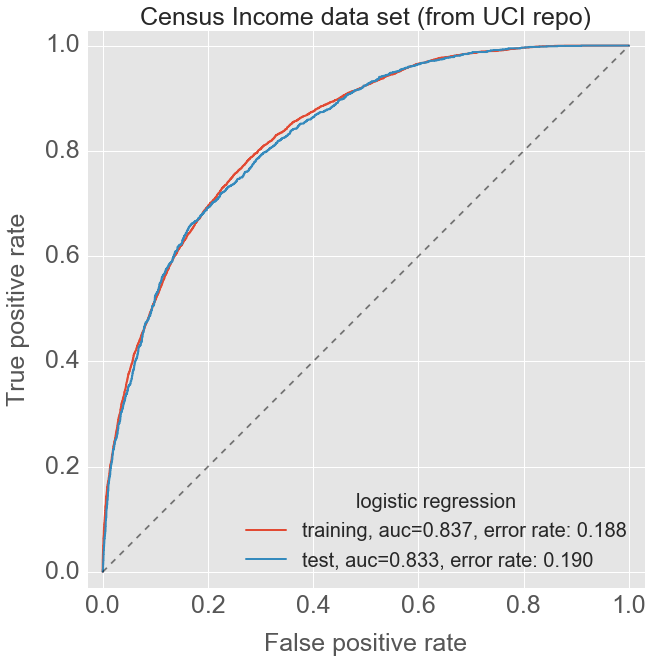

In [118]:
FONTSIZE = 25
plt.close('all')
fig, ax = plt.subplots(1, figsize=(10, 10))

train_p, = ax.plot(train_fpr, train_tpr, lw=2, markersize=0, label='train')
test_p, = ax.plot(test_fpr, test_tpr, lw=2, markersize=0, label='test')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax.set_xlim(-0.03, 1.03)
ax.set_ylim(-0.03, 1.03)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.set_xlabel('False positive rate', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('True positive rate', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Census Income data set (from UCI repo)', fontsize=FONTSIZE)
l = ax.legend([train_p, test_p],
              ['training, auc={0:.3f}, error rate: {1:.3f}'.format(train_roc_auc, train_error),
               'test, auc={0:.3f}, error rate: {1:.3f}'.format(test_roc_auc, test_error)],
              title='logistic regression', 
              fontsize=0.8*FONTSIZE, loc='best')
plt.setp(l.get_title(), fontsize=0.8*FONTSIZE)